In [4]:
!pip install eofs
!pip install esem
!pip install utils
!pip install netCDF4
!pip install xarray

In [5]:
import os

os.environ['HDF5_DISABLE_VERSION_CHECK'] = "1"

import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr

from sklearn import metrics

from eofs.xarray import Eof
from esem import rf_model

from utils import *

In [6]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [10]:
import numpy as np
import pandas as pd
import xarray as xr
from eofs.xarray import Eof
# data_path = './data/train_val/'
data_path = "/content/gdrive/MyDrive/climate_emulator_duncan_parris/train_val1/"

min_co2 = 0.
max_co2 = 9500
def normalize_co2(data):
    return data / max_co2

def un_normalize_co2(data):
    return data * max_co2

min_ch4 = 0.
max_ch4 = 0.8
def normalize_ch4(data):
    return data / max_ch4

def un_normalize_ch4(data):
    return data * max_ch4


def create_predictor_data(data_sets, n_eofs=5):
    """
    Args:
        data_sets list(str): names of datasets
        n_eofs (int): number of eofs to create for aerosol variables
    """

    # Create training and testing arrays
    if isinstance(data_sets, str):
        data_sets = [data_sets]
    X = xr.concat([xr.open_dataset(data_path + f"inputs_{file}.nc") for file in data_sets], dim='time')
    X = X.assign_coords(time=np.arange(len(X.time)))

    # Compute EOFs for BC
    bc_solver = Eof(X['BC'])
    bc_eofs = bc_solver.eofsAsCorrelation(neofs=n_eofs)
    bc_pcs = bc_solver.pcs(npcs=n_eofs, pcscaling=1)

    # Compute EOFs for SO2
    so2_solver = Eof(X['SO2'])
    so2_eofs = so2_solver.eofsAsCorrelation(neofs=n_eofs)
    so2_pcs = so2_solver.pcs(npcs=n_eofs, pcscaling=1)

    # Convert to pandas
    bc_df = bc_pcs.to_dataframe().unstack('mode')
    bc_df.columns = [f"BC_{i}" for i in range(n_eofs)]

    so2_df = so2_pcs.to_dataframe().unstack('mode')
    so2_df.columns = [f"SO2_{i}" for i in range(n_eofs)]

    # Bring the emissions data back together again and normalise
    inputs = pd.DataFrame({
        "CO2": normalize_co2(X["CO2"].data),
        "CH4": normalize_ch4(X["CH4"].data)
    }, index=X["CO2"].coords['time'].data)

    # Combine with aerosol EOFs
    inputs = pd.concat([inputs, bc_df, so2_df], axis=1)
    return inputs, (so2_solver, bc_solver)


def get_test_data(file, eof_solvers, n_eofs=5):
    """
    Args:
        file str: name of datasets
        n_eofs (int): number of eofs to create for aerosol variables
        eof_solvers (Eof_so2, Eof_bc): Fitted Eof objects to use for projection
    """

    # Create training and testing arrays
    X = xr.open_dataset(data_path + f"inputs_{file}.nc")

    so2_pcs = eof_solvers[0].projectField(X["SO2"], neofs=5, eofscaling=1)
    so2_df = so2_pcs.to_dataframe().unstack('mode')
    so2_df.columns = [f"SO2_{i}" for i in range(n_eofs)]

    bc_pcs = eof_solvers[1].projectField(X["BC"], neofs=5, eofscaling=1)
    bc_df = bc_pcs.to_dataframe().unstack('mode')
    bc_df.columns = [f"BC_{i}" for i in range(n_eofs)]

    # Bring the emissions data back together again and normalise
    inputs = pd.DataFrame({
        "CO2": normalize_co2(X["CO2"].data),
        "CH4": normalize_ch4(X["CH4"].data)
    }, index=X["CO2"].coords['time'].data)

    # Combine with aerosol EOFs
    inputs = pd.concat([inputs, bc_df, so2_df], axis=1)
    return inputs


def create_predictdand_data(data_sets):
    if isinstance(data_sets, str):
        data_sets = [data_sets]
    Y = xr.concat([xr.open_dataset(data_path + f"outputs_{file}.nc") for file in data_sets], dim='time').mean("member")
    # Convert the precip values to mm/day
    Y["pr"] *= 86400
    Y["pr90"] *= 86400
    return Y


def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth - pred)**2).weighted(weights).mean(['lat', 'lon'])).data

In [11]:
# path to save the netcdf file
path_output ='outputs_ssp245_prediction_ESEm.nc'

In [12]:
train_files = [ "historical", "ssp585", "ssp126", "ssp370", ]
# Create training and testing arrays
X, solvers = create_predictor_data(train_files)
Y = create_predictdand_data(train_files)

In [13]:
rf_tas = rf_model(X, Y['tas'], random_state=0, bootstrap=True, max_features='auto', **{'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 7,  'max_depth': 5,})
rf_pr = rf_model(X, Y['pr'], random_state=0, bootstrap=True, max_features='auto', **{'n_estimators': 150, 'min_samples_split': 15, 'min_samples_leaf': 8,'max_depth': 40,})
rf_pr90 = rf_model(X, Y['pr90'], random_state=0, bootstrap=True, max_features='auto',**{'n_estimators': 250, 'min_samples_split': 15, 'min_samples_leaf': 12,'max_depth': 25,})
rf_dtr = rf_model(X, Y["diurnal_temperature_range"], random_state=0, bootstrap=True, max_features='auto',**{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_depth': 20,})

rf_tas.train()
rf_pr.train()
rf_pr90.train()
rf_dtr.train()

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

In [14]:
## Test on SSP245

X_test = get_test_data('ssp245', solvers)
Y_test = create_predictdand_data(['ssp245'])

tas_truth = Y_test["tas"]
pr_truth = Y_test["pr"]
pr90_truth = Y_test["pr90"]
dtr_truth = Y_test["diurnal_temperature_range"]


In [15]:
m_out_tas, _ = rf_tas.predict(X_test)
m_out_pr, _ = rf_pr.predict(X_test)
m_out_pr90, _ = rf_pr90.predict(X_test)
m_out_dtr, _ = rf_dtr.predict(X_test)

In [16]:
xr_output = xr.Dataset(dict(tas=m_out_tas, pr=m_out_pr, pr90=m_out_pr90, diurnal_temperature_range=m_out_dtr)).assign_coords(time=m_out_tas.sample + 2014)
#save output to netcdf
xr_output.to_netcdf(path_output,'w')

In [17]:
print(f"RMSE: {get_rmse(tas_truth[35:], m_out_tas[35:]).mean()}")
print("\n")

print(f"RMSE: {get_rmse(dtr_truth[35:], m_out_dtr[35:]).mean()}")
print("\n")

print(f"RMSE: {get_rmse(pr_truth[35:], m_out_pr[35:]).mean()}")
print("\n")

print(f"RMSE: {get_rmse(pr90_truth[35:], m_out_pr90[35:]).mean()}")

RMSE: 0.5595709961735882


RMSE: 0.15835733899023294


RMSE: 0.5394265869027367


RMSE: 1.5462448434582696


In [18]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, check_scoring, mean_squared_error

def get_rmse_array(truth, pred):
    print(truth.shape, pred.shape)
    weights = np.cos(np.deg2rad(truth.lat))

    return np.sqrt(((truth - pred.reshape(-1, 96,144))**2).weighted(weights).mean(['lat', 'lon'])).data.mean()

In [ ]:
#%%time
#pr_result = permutation_importance(rf_pr.model.model, X_test[35:], pr_truth.sel(time=slice(2050,None)), n_repeats=10, random_state=42, n_jobs=1, scoring=make_scorer(get_rmse_array)

In [19]:
importances = rf_pr.model.model.feature_importances_

In [20]:
feature_names = list(X.columns)

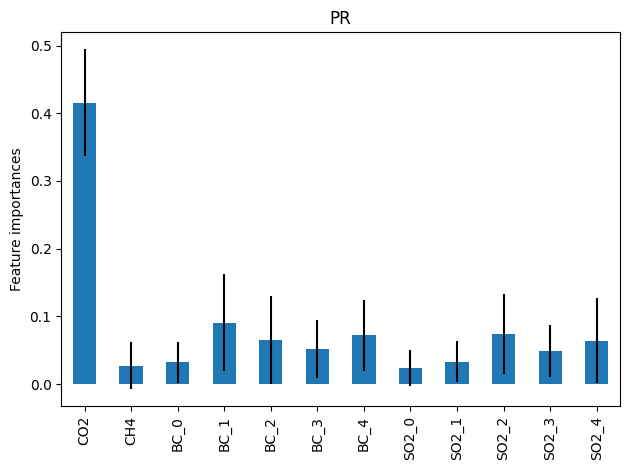

In [21]:
std = np.std([tree.feature_importances_ for tree in rf_pr.model.model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("PR")
ax.set_ylabel("Feature importances")
fig.tight_layout()